# load data
# selecct normal data
# train autoencoder
# loss of AP and pneumonia


In [3]:
%pip install -q "monai[pillow, tqdm]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
# FIXME: install MONAI from source code, will remove it when v0.4.0 released
%pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
print(torch.__version__)

1.6.0


In [6]:
import logging
import os
import shutil
import sys
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from skimage.util import random_noise


In [7]:
from monai.transforms import (
    AddChannelD,
    Compose,
    LoadImageD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityD,
    ToTensorD,
    Lambda,
)
from monai.utils import set_determinism

In [8]:
from monai.transforms import (
    LoadImage,
    AddChannel,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Transform,
)
from monai.data import CacheDataset, DataLoader
from autoencoder import AutoEncoder

In [9]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
img_path = "../data/size512/stage_2_train_images"

In [11]:
df = pd.read_csv("../data/size1024/df_PA.csv")

In [12]:
PA_df = df[(df['ViewPosition']=='PA')&(df['class']=='Normal')]

In [13]:
PA_ID = list(PA_df['patientId'])

In [20]:
len(PA_ID)

7214

In [14]:
img_list = [i for i in os.listdir(img_path) if i[:-4] in PA_ID]

In [15]:
all_filenames = [os.path.join(img_path ,i) for i in img_list]

In [16]:
test_frac = 0.2
num_test = int(len(all_filenames) * test_frac)
num_train = len(all_filenames) - num_test
train_datadict = [{"im": fname} for fname in all_filenames[:num_train]]
test_datadict = [{"im": fname} for fname in all_filenames[-num_test:]]

In [20]:
class LoadImage_m(Transform):
    def __call__(self, data):
        return plt.imread(data)

In [21]:
'''
NoiseLambda = Lambda(lambda d: {
    "orig":d["im"],
    "gaus":torch.tensor(random_noise(d["im"], mode='gaussian'), dtype=torch.float32),
    "s&p":torch.tensor(random_noise(d["im"], mode='s&p', salt_vs_pepper=0.1)),
})
'''
train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensorD(keys=["im"]),
        #NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        ToTensorD(keys=["im"]),
        #NoiseLambda,
    ]
)


batch_size = 4
num_workers = 6

train_ds = CacheDataset(train_datadict, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

Load and cache transformed data: 100%|██████████| 5772/5772 [01:14<00:00, 77.75it/s]


In [22]:
test_ds = CacheDataset(test_datadict, test_transforms, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=num_workers)

Load and cache transformed data: 100%|██████████| 1442/1442 [00:27<00:00, 52.04it/s]


In [23]:
def train(epoch_num=10, learning_rate=1e-3):
    
    model = AutoEncoder(
        dimensions=2,
        in_channels=1,
        out_channels=1,
        channels=(4, 8, 16, 32),
        strides=(2, 2, 2, 2),
    ).to(device)
    
        # Create loss fn and optimiser
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    epoch_loss_values = list()
    
    t = trange(epoch_num, desc=" -- epoch 0, avg loss: inf", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:        
            step += 1
            inputs = batch_data['im'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, batch_data['im'].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        t.set_description(f" -- epoch {epoch + 1}, average loss: {epoch_loss:.4f}")
    
    torch.save(model.state_dict(), './model.pth')
    
    return model, epoch_loss_values

In [24]:
epoch_num = 20
models = []
epoch_losses = []

model, epoch_loss = train(epoch_num=epoch_num)
models.append(model)
epoch_losses.append(epoch_loss)

 -- epoch 20, average loss: 0.0015: 100%|██████████| 20/20 [22:10<00:00, 66.50s/it]


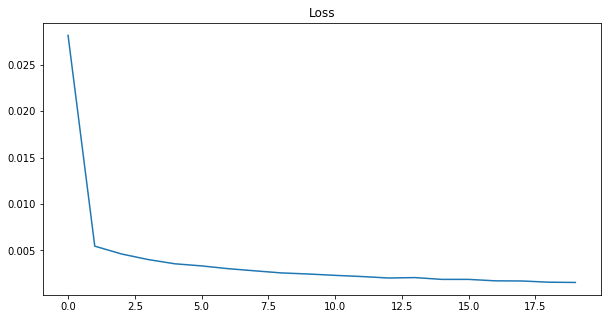

In [25]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(epoch_losses[0])

In [26]:
# Create small visualistaion function
def plot_ims(ims, shape=None, figsize=(10,10), titles=None):
    shape = (1,len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i,im in enumerate(ims):
        plt.subplot(*shape,i+1)
        im = plt.imread(im) if isinstance(im, str) else torch.squeeze(im)
        plt.imshow(im, cmap='gray')
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=10, shuffle=True)
    itera = iter(loader)
    return next(itera)

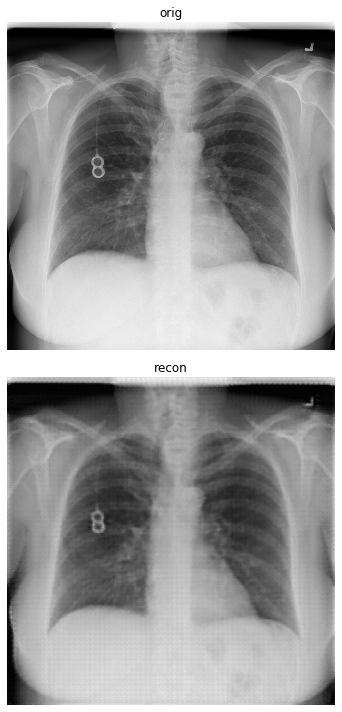

In [41]:
data = get_single_im(test_ds)

model.eval()
recons = []
im = data['im']
recon = model(im.to(device)).detach().cpu()
recons.append(recon)

plot_ims(
    [im] + [recons[0]], 
    titles=['orig'] + ["recon"] ,
    shape=(2,1))

## AP dataset

In [29]:
(df['ViewPosition'].unique())

array(['PA'], dtype=object)

In [5]:
df = pd.read_csv("../data/final_df.csv")

In [31]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'SOPInstanceUID', 'AccessionNumber',
       'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex',
       'PatientAge', 'ViewPosition', 'StudyInstanceUID', 'SeriesInstanceUID',
       'StudyID', 'PatientOrientation', 'Unnamed: 0_y', 'patientId', 'x', 'y',
       'width', 'height', 'Target', 'class'],
      dtype='object')

In [6]:
df['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [32]:
AP_df = df[(df['ViewPosition']=='AP')&(df['class']=='Normal')]

In [33]:
AP_ID = list(AP_df['patientId'])

In [34]:
len(AP_ID)

1637

In [35]:
img_list = [i for i in os.listdir(img_path) if i[:-4] in AP_ID]

In [36]:
all_filenames = [os.path.join(img_path ,i) for i in img_list]

In [37]:
len(all_filenames)

1637

In [38]:
AP_test_datadict = [{"im": fname} for fname in all_filenames]

In [63]:
num_workers = 4
AP_test_ds = CacheDataset(AP_test_datadict, test_transforms, num_workers=num_workers)
AP_test_loader = DataLoader(AP_test_ds, batch_size=1, shuffle=True, num_workers=num_workers)

Load and cache transformed data: 100%|██████████| 1637/1637 [00:27<00:00, 59.37it/s]


In [40]:
def evaluation(dataset_type):
    model.eval()
    loss_dist = []
    loss_function = torch.nn.MSELoss()

    for batch_data in dataset_type:        
        inputs = batch_data['im'].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, batch_data['im'].to(device))
        loss_dist.append(loss.item())
        
    return loss_dist

In [64]:
test_types = ['PA','AP']
test_dataset_types = [test_loader, AP_test_loader]
test_losses = []
for i in test_dataset_types:
    test_loss = evaluation(i)
    test_losses.append(test_loss)

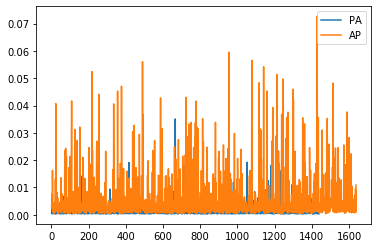

In [65]:
plt.figure()
for y, label in zip(test_losses, test_types):
    x = list(range(1, len(y)+1))
    line, = plt.plot(x, y)
    line.set_label(label)
plt.legend();

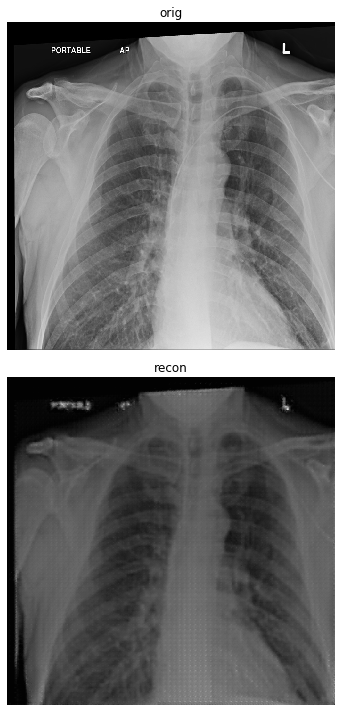

In [66]:
data = get_single_im(AP_test_ds)

model.eval()
recons = []
im = data['im']
recon = model(im.to(device)).detach().cpu()
recons.append(recon)

plot_ims(
    [im] + [recons[0]], 
    titles=['orig'] + ["recon"] ,
    shape=(2,1))

In [46]:
import seaborn as sns

In [ ]:
lower_threshold = 0.0
upper_threshold = 0.0015
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(test_losses[0],bins=100,kde=True, color='blue')
sns.distplot(test_losses[1],bins=100,kde=True, color='orange')
#plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='r')
plt.set_label('PA','AP')

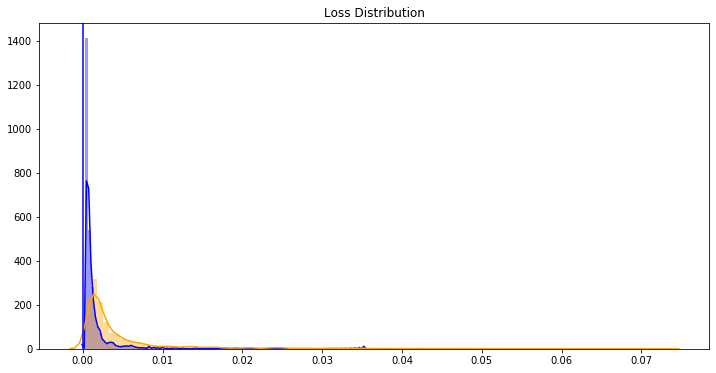

In [73]:
lower_threshold = 0.0
upper_threshold = 0.0015
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(test_losses[0],bins=100,kde=True, color='blue')
sns.distplot(test_losses[1],bins=100,kde=True, color='orange')
#plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')


## ROC AUC

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [68]:
len(test_loader)

1442

In [69]:
len(AP_test_loader)

1637

In [70]:
y_test = [0]*len(test_losses[0]) + [1]*len(test_losses[1])
y_pred = test_losses[0] + test_losses[1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [71]:
# calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)

AUC: 0.833


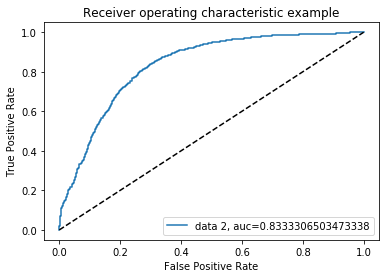

In [72]:
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()